# Natural Computing - Assignment 1 - Evolutionary Computation
## Exercise 6 - Memetic Algorithms vs Simple EAs
#### Submission by group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

This file contains our solution to exercise 6 of the "Evolutionary Computation" assignment of the Natural Computing course.<br><br>




# Instructions

## TSP instances
Make sure that the folder in which this notebook is stored contains the TSP instances in .txt format. 
### loading TSP instances
The following code can be used to load the TSP instances
```
tsp = np.genfromtxt(fname='file-tsp.txt')
tour = np.arange(len(tsp)) ## necessary to create the tours

```

## Running the Simple Evolutionary Algorithm
The following code can be used to run the simple evolutionary algorithm. Modify the iters and pm parameters if you would like to run more or fewer iterations or use a modified mutation rate.
```
avg_fitness, best_fitness = tsp_GA(tsp,iters=1500,pm=0.01)
```


## Running the Memetic Algorithm
The following code can be used to run the memetic algorithm.Modify the iters and pm parameters if you would like to run more or fewer iterations or use a modified mutation rate.
```
avg_fitness_memetic, best_fitness_memetic  = tsp_memetic(tsp,iters=1500,pm=0.01)
```

# Examples
The last two cells contain examples for two TSP instances, the first TSP instance is provided with the course  and the second TSP instance is the 48 US capital TSP(Padberg/Rinaldi) [att48.tsp](http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsplib.html).

In [1]:
import numpy as np
import math
import pdb
import matplotlib.pyplot as plt
import pdb
from itertools import combinations


In [2]:
def calculate_fitness(tour, tsp):
    fitness = 0
    for i in range(0,len(tour)-1):
        start = tsp[tour[i]]
        end = tsp[tour[i+1]]
        fitness = fitness + math.dist(start, end)
    return fitness

def generate_tour(tsp):
    tour = np.arange(len(tsp))
    np.random.shuffle(tour)
    return tour

In [3]:
def initialize_population(size, tsp):
    population = []
    for i in range(size):
        tour = generate_tour(tsp)
        population.append(tour)
    return population

def tournament_selection(population, k = 5):
#     idx = np.random.randint( 0, len(population) , size=k) #replacement?
    idx = np.random.choice( range(0,len(population)) , size=5, replace=False)

    population = np.array(population)
    k_candidates = population[idx, :]

    p1 = None
    best_fitness = 9999
    
    for p in k_candidates:
        p_fitness = calculate_fitness(p, tsp)
        if p_fitness < best_fitness:
            best_fitness = p_fitness
            p1 = p
    
    np.delete(population, p1)
    
    
    idx = np.random.choice( range(0,len(population)) , size=5, replace=False)
    k_candidates = population[idx, :]

    p2 = None
    best_fitness = 9999
    
    for p in k_candidates:
        p_fitness = calculate_fitness(p, tsp)
        if p_fitness < best_fitness:
            best_fitness = p_fitness
            p2 = p
    
    return p1, p2
        

def random_mutation(population, pm = 0.01):
    for p in population:
        probabilities = np.random.rand(len(p))
        mutations = np.where(probabilities < pm)[0]
        if len(mutations) > 1:
            for idx in range(0, len(mutations)-1):
                p[[mutations[idx], mutations[idx+1]]] = p[[mutations[idx+1], mutations[idx]]]
    
    return population

def random_crossover(parent1, parent2, population, fitness):
    idx_to_replace = np.argsort(fitness)[-2:]
    
    cut = np.random.randint(0, len(parent1)+1, 2)
    
    offspring1 = np.zeros(len(parent1))
    offspring2 = np.zeros(len(parent2))
    
    offspring1[min(cut):max(cut)] = parent1[min(cut):max(cut)]
    offspring2[min(cut):max(cut)] = parent2[min(cut):max(cut)]

    
    counter = 0
    for i in range(0, len(parent2)):
        idx = (i + max(cut)) % len(parent2)
        city = parent2[idx]
        if not city in offspring1:
            placement = (max(cut) + counter) % len(parent2)
            offspring1[placement] = city
            counter = counter + 1
        
    counter = 0
    for i in range(0, len(parent1)):
        idx = (i + max(cut)) % len(parent1)
        city = parent1[idx]
        if not city in offspring2:
            placement = (max(cut) + counter) % len(parent1)
            offspring2[placement] = city
            counter = counter + 1
    #population = np.array(population)
    
    return offspring1, offspring2

def tsp_EA(tsp, iters = 1500, pm = 0.01):
    avg_fitness = []
    best_fitness = []
    population_size = 25
    population = initialize_population(population_size, tsp)
    
    fitness = []
    for p in population:
        fitness.append(calculate_fitness(p, tsp))
    
    avg_fitness.append(np.average(fitness))
    best_fitness.append(min(fitness))
    
    for i in range(0, iters):
        #print("Iteration {}:".format(i+1))
        
        # Tournament Selection
        parent1, parent2 = tournament_selection(population, k = 5)
        
        # Perform Crossover
        offspring1, offspring2 = random_crossover(parent1, parent2, population, fitness)
        
        # Perform Random Mutation
        mutated_offspring = random_mutation([offspring1, offspring2], pm)

        idx_to_replace = np.argsort(fitness)[-2:]
        population = np.array(population)
        population[idx_to_replace] = mutated_offspring
        
        fitness = []
        for p in population:
            fitness.append(calculate_fitness(p, tsp))
        avg_fitness.append(np.average(fitness))
        best_fitness.append(min(fitness))
        
    return avg_fitness, best_fitness

In [4]:
## create matrix with all distances for tsp...
def create_distance_matrix(tsp):
    distance_matrix = np.zeros((len(tsp),len(tsp)))

    for index,x  in np.ndenumerate(distance_matrix):
        if index[0] is not index[1]:
            distance_matrix[index] = math.dist(tsp[index[0]],tsp[index[1]])
        else:
            distance_matrix[index] = 9999
    return distance_matrix

In [5]:
def city_combinations(cities):
    non_repeating_combinations = list(sorted(set(combinations(cities,r=2))))
    combination_matrix = np.reshape(non_repeating_combinations, newshape=(len(non_repeating_combinations), 2))
    ## split them based on the starting city
    splitted = np.split(combination_matrix, np.where(np.diff(combination_matrix[:,0]))[0]+1)
    return splitted

In [6]:
def find_end_city(tour, start_city):
    first_index = tour.index(start_city)
    end_city = tour[first_index + 1]
    return end_city

In [7]:
def two_opt(tsp, current_tour, distance_matrix, return_fitness = False):
    
    possible_city_combinations = city_combinations(current_tour)

    current_best_tour = current_tour

    current_best_tour_fitness = calculate_fitness(current_tour, tsp)
    
    for combination_set in possible_city_combinations:
        start_city = combination_set[0][0] # first element is always starting city..
        end_city = find_end_city(current_tour.tolist(), start_city) # the current city connect to start city
        current_combination = (start_city, end_city)  
        current_combination_distance = distance_matrix[start_city,end_city]
        
        smallest_distance_combination = sorted(combination_set, key = lambda combination: distance_matrix[combination[0],combination[1]]) 
        
        #onhandig
        smallest_distance = distance_matrix[smallest_distance_combination[0][0], smallest_distance_combination[0][1]]
        if smallest_distance < current_combination_distance:
            ## swap
            
            ### indices of the cities in the current tour
            old_city_two = current_tour.tolist().index(end_city)
            new_city_two = current_tour.tolist().index(smallest_distance_combination[0][1])
            
            
            ### constructing new tour
            new_tour = current_tour.copy()
            new_tour[old_city_two] = smallest_distance_combination[0][1]
            new_tour[new_city_two] = end_city
            
            new_tour_fitness = calculate_fitness(new_tour,tsp)
            
            if new_tour_fitness < current_best_tour_fitness:
                current_best_tour_fitness = new_tour_fitness
                current_best_tour = new_tour
    if return_fitness:
        return current_best_tour,current_best_tour_fitness
    else:
        return current_best_tour

In [8]:
def tsp_memetic(tsp, iters = 1500, pm = 0.01):
    avg_fitness = []
    best_fitness = []
    population_size = 25
    population = initialize_population(population_size, tsp)
    
    distance_matrix = create_distance_matrix(tsp)
    
    fitness = []
    for p in population:
        local_search_p,local_search_fitness = two_opt(tsp,p,distance_matrix, return_fitness =True)
        fitness.append(local_search_fitness)
    ## local search to each individual

    avg_fitness.append(np.average(fitness))
    best_fitness.append(min(fitness))
    
    for i in range(0, iters):
        #print("Iteration {}:".format(i+1))
        
        # Tournament Selection
        parent1, parent2 = tournament_selection(population, k = 5)
        
        
        # Perform Crossover
        offspring1, offspring2 = random_crossover(parent1, parent2, population, fitness)

        # Perform Random Mutation
        mutated_offspring = random_mutation([offspring1, offspring2], pm)

        # Local Search
        local_search_offspring = [two_opt(tsp, offspring.astype(np.int64),distance_matrix) for offspring in mutated_offspring]

        idx_to_replace = np.argsort(fitness)[-2:]
        population = np.array(population)

        population[idx_to_replace] = local_search_offspring

        
        fitness = []
        for p in population:
            fitness.append(calculate_fitness(p, tsp))
        avg_fitness.append(np.average(fitness))
        best_fitness.append(min(fitness))
        
    return avg_fitness, best_fitness

# Examples

### TSP instance 1

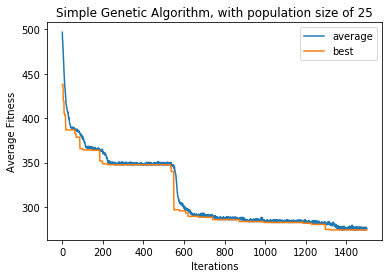

In [9]:
tsp = np.genfromtxt(fname='file-tsp.txt') ## load tsp instance
tour = np.arange(len(tsp)) ## create tour

avg_fitness, best_fitness = tsp_EA(tsp, iters=1500, pm=0.01) ## run algorithm

## optional, plot results
plt.plot(avg_fitness)
plt.plot(best_fitness)
plt.title('Simple Genetic Algorithm, with population size of 25')
plt.xlabel('Iterations')
plt.ylabel('Average Fitness')
plt.legend(['average', 'best'])
plt.show()

### TSP instance 2, 48 capital US 

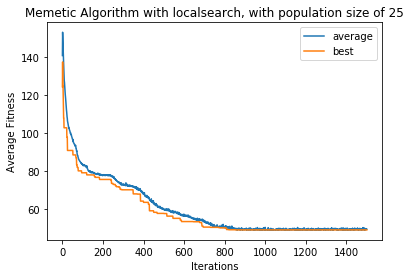

In [10]:
tsp2 =  np.genfromtxt(fname='file-tsp2.txt') ## load tsp instance
tsp2 = tsp2/1000 #scale down all values
tour2 = np.arange(len(tsp2)) ## create tour

avg_fitness_memetic_tsp2, best_fitness_memetic_tsp2  = tsp_memetic(tsp2,iters=1500,pm=0.01) ## run algorithm

## optional, plot results
plt.plot(avg_fitness_memetic_tsp2)
plt.plot(best_fitness_memetic_tsp2)
plt.title('Memetic Algorithm with localsearch, with population size of 25')
plt.xlabel('Iterations')
plt.ylabel('Average Fitness')
plt.legend(['average', 'best'])
plt.show()